In [5]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import os
import csv

import PIL
from PIL import ImageDraw

%matplotlib inline

### Visualize

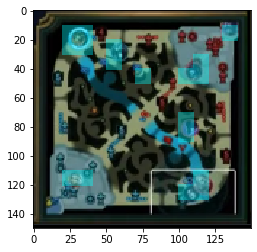

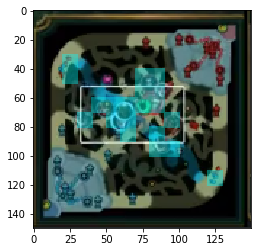

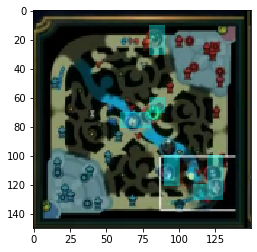

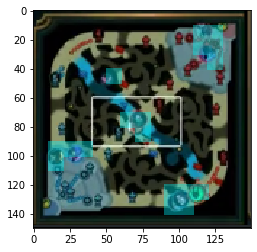

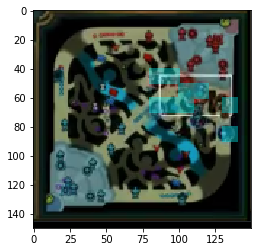

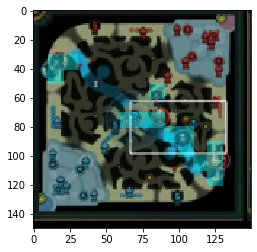

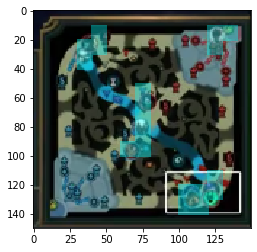

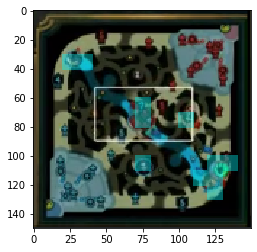

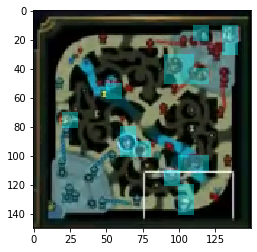

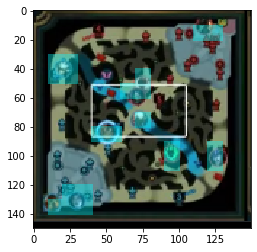

In [9]:
data_dir = "games_collected"
grid_size = 10
def draw_grid(draw, grids):
    fill = (0, 255, 255, 96)
    for g in grids:
        x = g[0] * grid_size
        y = g[1] * grid_size
        draw.rectangle((x, y, x + grid_size, y + grid_size), fill=fill)
        
# def process(image):
#     plt.figure()
#     plt.imshow(image)
        
def draw_preds():
    i = 1000
    indexes = range(i,i+100,10)
    with open(data_dir+'/full_coordinates.csv', 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',', quotechar='|')
        next(reader)
        i = 0
        for row in reader:
            i+=1
            if i < indexes[0] or i >= indexes[1]:
                continue
            img = PIL.Image.open(data_dir+"/full/"+row[0]+".png")
            grids = [(int(i.split("-")[0]), int(i.split("-")[1])) for i in row[1].split(" ")]
            overlay = PIL.Image.new('RGBA', img.size, (255, 255, 255, 0))
            draw = ImageDraw.Draw(overlay)
            draw_grid(draw, grids)
            out = PIL.Image.alpha_composite(img, overlay)
            plt.figure()
            plt.imshow(out)
    
draw_preds()